In [17]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import importlib
from modules import base_model as bm 
from modules import obstacles as obs
from modules import run_simulation
from modules import attractor as att

importlib.reload(bm); importlib.reload(obs); importlib.reload(run_simulation); importlib.reload(att)
print(f'Imported modules successfully!')

Imported modules successfully!


In [18]:
# Just for testing lists 
obstacle_params = [[1, 2, 3, 4], [2, 3, 4, 55], [3]] 

if not(all(isinstance(i, list) for i in obstacle_params)):
        # If it's just a list, make it a list of lists.
        print(f'Changing.')
        obstacle_params = np.array([obstacle_params])

obstacle_params

[[1, 2, 3, 4], [2, 3, 4, 55], [3]]

#### After meeting on 24/11:
Flossie to look at real world data. Maybe start the writing.<br>
Colm to do the qualitative/quantitative success rates.<br>
Ruby to incorporate her wind into the obstacle version.

I will:
- Introduce a 'steer-to-avoid' version.
- Find a way to have the obstacles remove birds from the system.

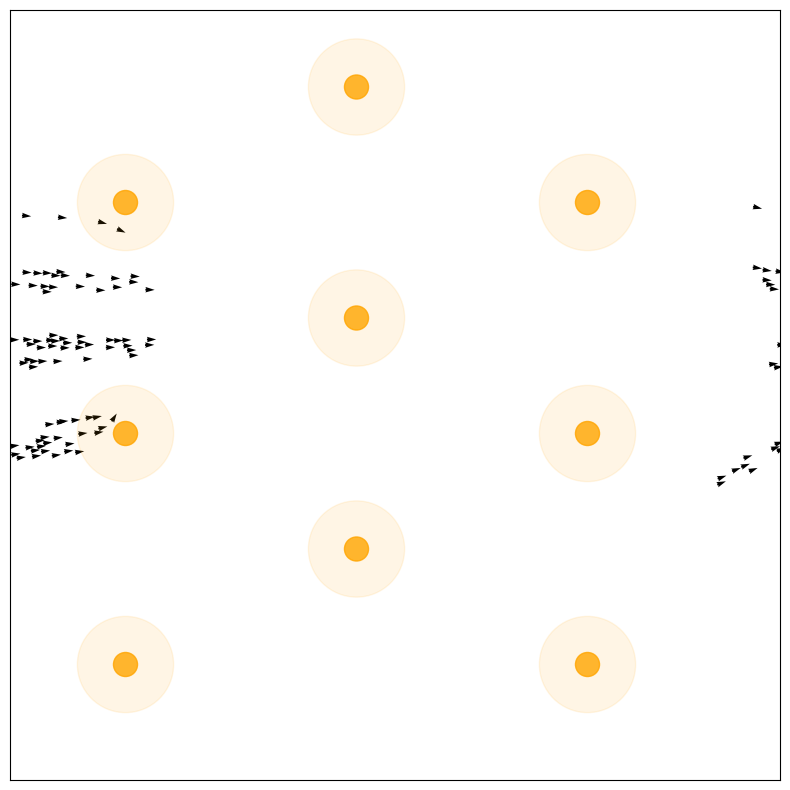

In [ ]:
# v0, eta, L, dt, Nt, N
model_params = [0.3, 0.6, 10, 0.2, 200, 100]

# lam_c, lam_a, lam_m, lam_att, A, R.
strength_params = [0.2, 0.8, 0.4, 0.2, 0.15, 1.25]

# As many obstacle params as we can without overlapping
lam_o = 1
O_rad = 1.25

obstacle_params = np.array([
 [lam_o, 1.5, 1.5, O_rad],
 [lam_o, 1.5, 4.5, O_rad],
 [lam_o, 1.5, 7.5, O_rad],

 [lam_o, 4.5, 3.0, O_rad],
 [lam_o, 4.5, 6.0, O_rad],
 [lam_o, 4.5, 9.0, O_rad],

 [lam_o, 7.5, 1.5, O_rad],
 [lam_o, 7.5, 4.5, O_rad],
 [lam_o, 7.5, 7.5, O_rad]
])

attractor_pos = np.array([15, 6])

# Let's scale everything by ? for the fun of it?
scale = 2
model_params[2] = model_params[2] * scale
obstacle_params[:, 1] *= scale
obstacle_params[:, 2] *= scale
attractor_pos = attractor_pos * scale


# run_simulation.plot_simulation_att(model_params, strength_params, obstacle_params, attractor_pos, init_left = True)
# See markdown comments.